In [5]:
import pandas as pd
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
# Load the CSV file
df = pd.read_csv('RSNA_breast_cancer_data.csv')

# Function to load DICOM images and resize them (using your existing approach)
def load_dicom_image(image_path, target_size=(224, 224)):  # Resize to 224x224 for ResNet101
    dicom = pydicom.dcmread(image_path)
    image = dicom.pixel_array
    image_resized = cv2.resize(image, target_size)
    image_normalized = image_resized / np.max(image_resized)  # Normalize pixel values
    
    # Convert grayscale to 3 channels by replicating the grayscale image
    image_rgb = np.stack([image_normalized] * 3, axis=-1)  # Replicate across 3 channels
    return image_rgb

# Load all the images and labels
image_paths = df['image_path'].values
labels = df['cancer'].values

In [4]:
# Prepare data
images = []
for path in image_paths:
    image = load_dicom_image(path)  # Directly use the full path from the CSV
    images.append(image)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with shape {images.shape}")

Loaded 2374 images with shape (2374, 224, 224, 3)


In [5]:
# Train-test-validation split (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Build the autoencoder model for feature extraction
input_img = Input(shape=(224, 224, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy')

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    # Stop training when the validation loss has stopped improving for 10 epochs
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, mode="min"),
    
    # Reduce learning rate if the validation loss does not improve for 5 epochs
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, mode="min")
]

# Train the autoencoder with validation and callbacks
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=100, 
                          batch_size=32, 
                          validation_data=(X_val, X_val),
                          callbacks=callbacks)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - loss: 0.4424 - val_loss: 0.2508 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - loss: 0.2351 - val_loss: 0.2276 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 0.2310 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.2254 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.2208 - val_loss: 0.2212 - learning_rate: 0.0010
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 0.2218 - val_loss: 0.2221 - learning_rate: 0.0010
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 0.2182 - val_loss: 0.2198 - learning_rate: 0.0010
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - loss: 0.2232 - val_loss: 0.2193 - learning_rate: 0.0010
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - loss: 0.2195 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 10/100
60

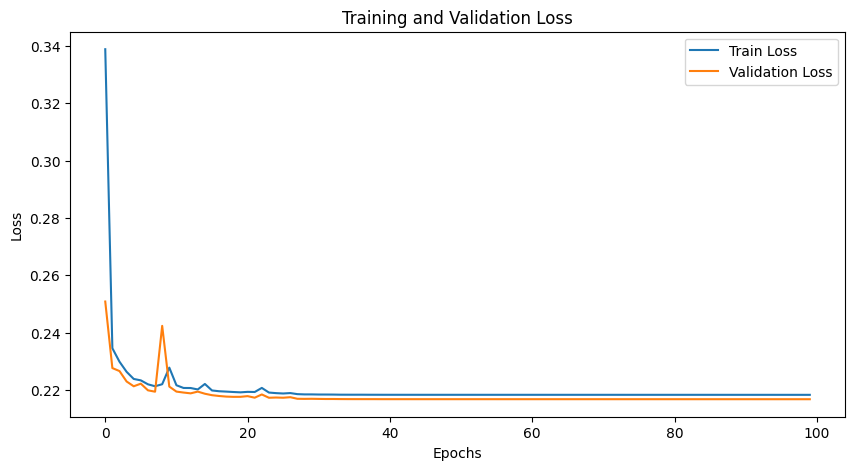

In [8]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features from the training, validation, and test sets
train_features = encoder.predict(X_train)
val_features = encoder.predict(X_val)
test_features = encoder.predict(X_test)

# Flatten the features to feed them into a classifier
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

## Without LDA

In [ ]:
## Finding best parameters
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
kernel = ['linear', 'rbf']
param_grid = dict(gamma=gamma_range, C=C_range, kernel = kernel)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create the SVM model
svm = SVC(probability=True)

# Perform grid search with cross-validation to find the best hyperparameters
grid = GridSearchCV(svm, param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(train_features_flat, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [ ]:
# Get the best estimator from the grid search
best_svm = grid.best_estimator_

In [10]:
# Evaluate on the validation set
val_preds = best_svm.predict(val_features_flat)
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.6793


In [11]:
# Final evaluation on the test set
test_preds = best_svm.predict(test_features_flat)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6765


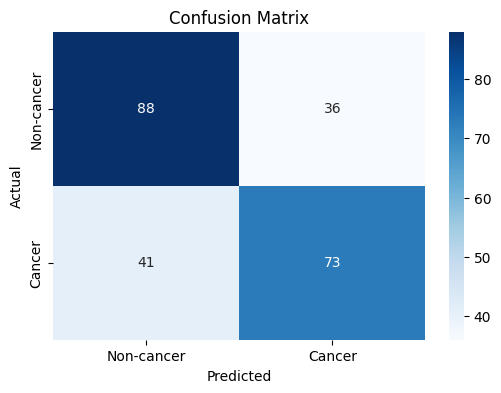

In [12]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancer', 'Cancer'], yticklabels=['Non-cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

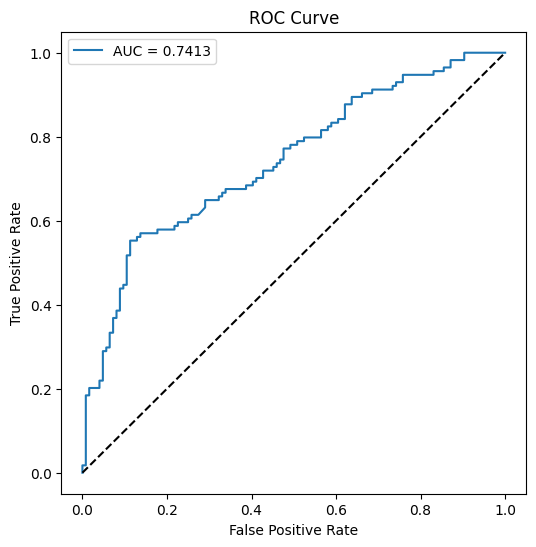

In [13]:
# Compute ROC curve and AUC
y_test_prob = svm.predict_proba(test_features_flat)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


--------

## With LDA

In [6]:
# Train-test-validation split (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Build the autoencoder model for feature extraction
input_img = Input(shape=(224, 224, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy')

In [8]:
# Train the autoencoder with validation
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=20, 
                          batch_size=32, 
                          validation_data=(X_val, X_val))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - loss: 0.4319 - val_loss: 0.2295
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.2341 - val_loss: 0.2278
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.2247 - val_loss: 0.2227
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.2252 - val_loss: 0.2312
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.2312 - val_loss: 0.2224
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 0.2222 - val_loss: 0.2205
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.2249 - val_loss: 0.2204
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.2256 - val_loss: 0.2199
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.2222 - val_loss: 0.2198
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - loss: 0.2214 - val_loss: 0.2233
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 0.2223 - val_loss: 0.2187
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - loss: 0.2213 - val_lo

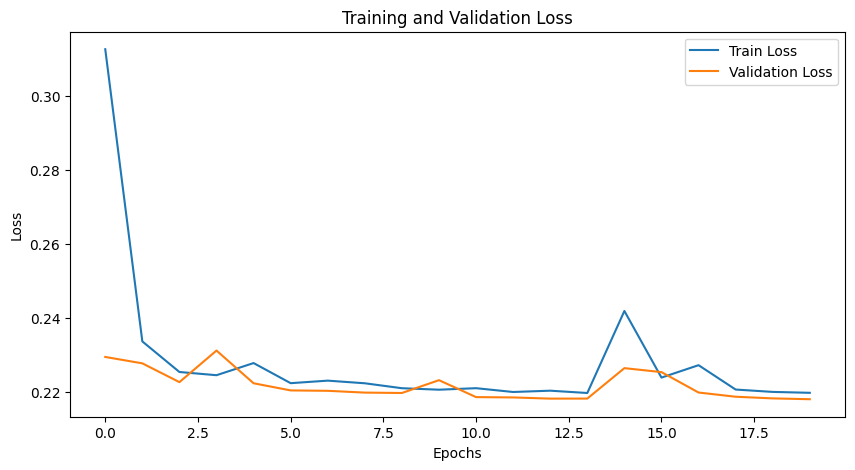

In [9]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# Encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features from the training, validation, and test sets
train_features = encoder.predict(X_train)
val_features = encoder.predict(X_val)
test_features = encoder.predict(X_test)

# Flatten the features to feed them into a classifier
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [12]:
# Applying LDA to the extracted features (train, val, test)
lda = LDA(n_components=1)

# Fit LDA on training features and transform the data
train_features_lda = lda.fit_transform(train_features_flat, y_train)
val_features_lda = lda.transform(val_features_flat)
test_features_lda = lda.transform(test_features_flat)

In [13]:
## Finding best parameters
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
kernel = ['linear', 'rbf']
param_grid = dict(gamma=gamma_range, C=C_range, kernel = kernel)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create the SVM model
svm = SVC(probability=True)

# Perform grid search with cross-validation to find the best hyperparameters
grid = GridSearchCV(svm, param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(train_features_lda, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': np.float64(0.01), 'gamma': np.float64(1e-09), 'kernel': 'linear'} with a score of 1.00


In [15]:
# Get the best estimator from the grid search
best_svm = grid.best_estimator_

In [16]:
# Final evaluation on test data
test_predictions = best_svm.predict(test_features_lda)
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, test_predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.56      0.55       124
           1       0.51      0.50      0.50       114

    accuracy                           0.53       238
   macro avg       0.53      0.53      0.53       238
weighted avg       0.53      0.53      0.53       238




Confusion Matrix:
 [[69 55]
 [57 57]]


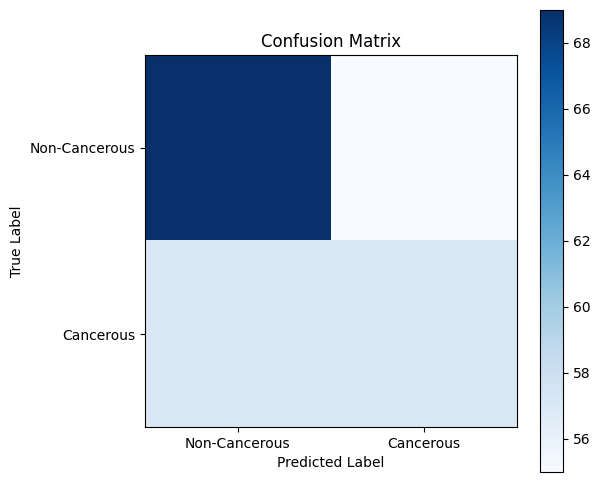

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
print("\nConfusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.yticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

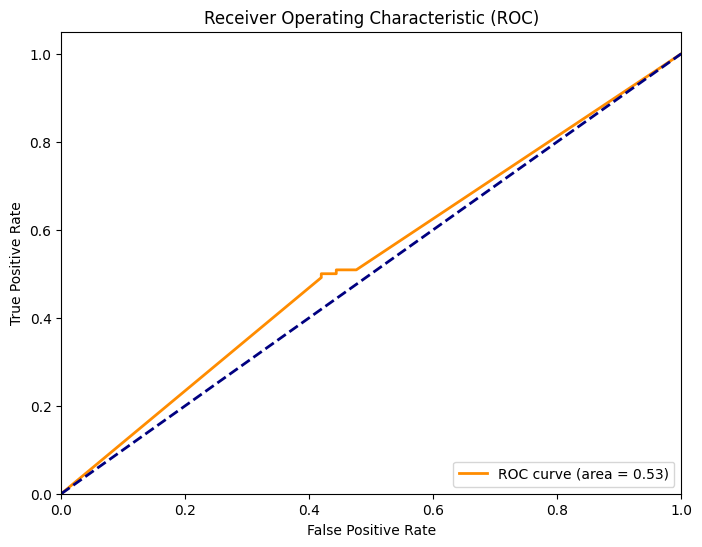

In [18]:
# ROC Curve
y_pred_prob = best_svm.predict_proba(test_features_lda)[:, 1]  # Probability for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

----------

## slightly complex model With LDA

In [19]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [20]:
# Train-test-validation split (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
# Build the autoencoder model with improvements
input_img = Input(shape=(224, 224, 3))

# Encoder with more layers and Batch Normalization
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

encoded = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer='l2')(x)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

# Decoder
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 224x224x64
x = BatchNormalization()(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy')

# Print model summary to ensure the structure is correct
# autoencoder.summary()

In [25]:
# Train the autoencoder with validation
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=20, 
                          batch_size=32, 
                          validation_data=(X_val, X_val))

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 530s 9s/step - loss: 3.9833 - val_loss: 3.2454
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 604s 10s/step - loss: 0.4422 - val_loss: 2.2077
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 539s 9s/step - loss: 0.7977 - val_loss: 0.8100
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 505s 8s/step - loss: 0.5318 - val_loss: 0.6506
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - loss: 0.5665 - val_loss: 1.7095
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 507s 8s/step - loss: 0.6462 - val_loss: 0.6027
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - loss: 0.3911 - val_loss: 0.5347
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 444s 7s/step - loss: 0.3235 - val_loss: 0.4849
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - loss: 0.2919 - val_loss: 0.5349
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - loss: 0.2836 - val_loss: 0.4765
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 430s 7s/step - loss: 0.2689 - val_loss: 0.4669
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 430s 7s/step - loss: 0.

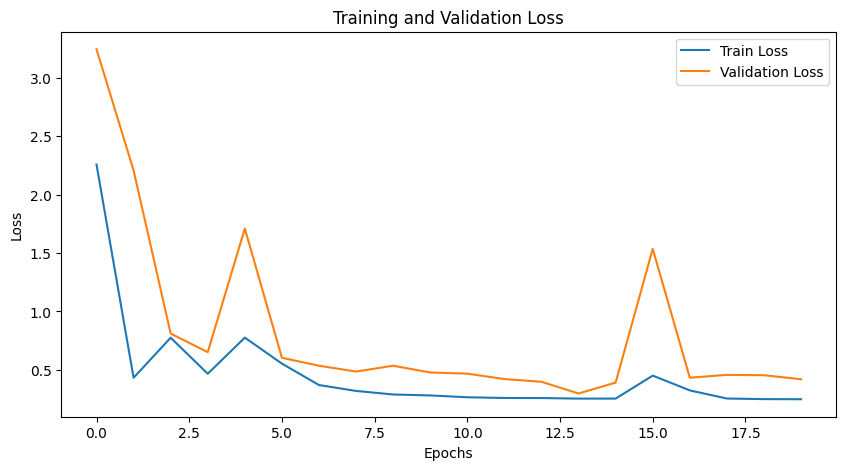

In [26]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [27]:
# Encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features from the training, validation, and test sets
train_features = encoder.predict(X_train)
val_features = encoder.predict(X_val)
test_features = encoder.predict(X_test)

# Flatten the features to feed them into a classifier
train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 613ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 563ms/step


In [28]:
# Classification using SVM
svm = SVC(kernel='linear', probability=True)
svm.fit(train_features_flat, 
        y_train)

SVC(kernel='linear', probability=True)

In [ ]:
## Finding best parameters
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
kernel = ['linear', 'rbf']
param_grid = dict(gamma=gamma_range, C=C_range, kernel = kernel)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create the SVM model
svm = SVC(probability=True)

# Perform grid search with cross-validation to find the best hyperparameters
grid = GridSearchCV(svm, param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(train_features_flat, 
        y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

In [29]:
# Final evaluation on the test set
test_preds = svm.predict(test_features_flat)
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6933


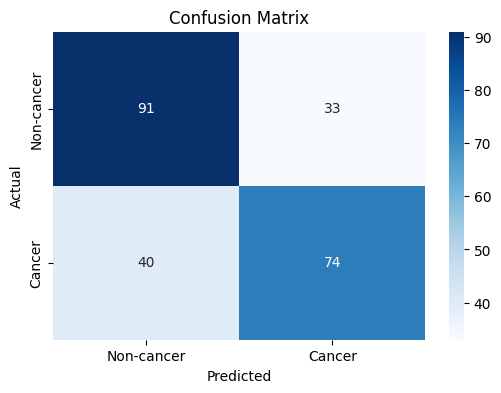

In [30]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-cancer', 'Cancer'], yticklabels=['Non-cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

------------------

## slightly complex model With LDA

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [32]:
# Applying LDA to the extracted features (train, val, test)
lda = LDA(n_components=1)

# Fit LDA on training features and transform the data
train_features_lda = lda.fit_transform(train_features_flat, y_train)
val_features_lda = lda.transform(val_features_flat)
test_features_lda = lda.transform(test_features_flat)

In [33]:
## Finding best parameters
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
kernel = ['linear', 'rbf']
param_grid = dict(gamma=gamma_range, C=C_range, kernel = kernel)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Create the SVM model
svm = SVC(probability=True)

# Perform grid search with cross-validation to find the best hyperparameters
grid = GridSearchCV(svm, param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(train_features_lda, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': np.float64(0.01), 'gamma': np.float64(1e-09), 'kernel': 'linear'} with a score of 1.00


In [36]:
# Get the best estimator from the grid search
best_svm = grid.best_estimator_

In [37]:
# Final evaluation on test data
test_predictions = best_svm.predict(test_features_lda)
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, test_predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.59      0.60       124
           1       0.56      0.58      0.57       114

    accuracy                           0.58       238
   macro avg       0.58      0.58      0.58       238
weighted avg       0.58      0.58      0.58       238




Confusion Matrix:
 [[73 51]
 [48 66]]


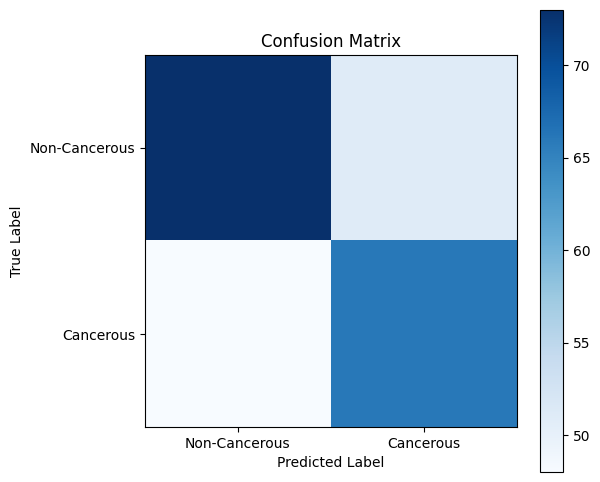

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
print("\nConfusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.yticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()